In [170]:
import requests   
import json
import pprint
import numpy as np
import pandas as pd
from functools import reduce
from pandas.tools.plotting import scatter_matrix
from matplotlib import pyplot as plt
import itertools
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### 1.a Static Data

In [171]:
wh = pd.read_excel('WHRData.xls', index_col=0)
wh = wh.reset_index()
wh = wh.rename(columns={'Country name': 'country', 'Year': 'year'})

wh.head()

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
0,Afghanistan,2008,3.723590,7.168690,0.450662,50.799999,0.718114,0.177889,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,51.200001,0.678896,0.200178,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906,0.286315,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2010,4.758381,7.386629,0.539075,51.599998,0.600127,0.134353,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318,0.275833,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2011,3.831719,7.415019,0.521104,51.919998,0.495901,0.172137,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2012,3.782938,7.517126,0.520637,52.240002,0.530935,0.244273,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.b Dynamic data (using world bank api)

In [172]:
class WorldBankDataFetcher:
    """
    """
    
    def __init__(self, indicators):
        self.indicators = indicators
        self.jsons = self.dataframes = []
        self.merged_data = None        

    def fetch_json_by(self, indicator):
        url = "http://api.worldbank.org/v2/countries/all/indicators/%s&format=json&per_page=9000" % (indicator + '?date=2000:2018')
        r = requests.get(url)    
        return json.loads(r.content)

    def json_to_df(self, j):
        indicator_name = j[1][0]['indicator']['value']
        df = pd.DataFrame.from_dict(j[1])
        df['country'] = df[['country']].applymap(lambda x : x['value'])
        df = df[['country', 'countryiso3code', 'date', 'value']]
        df.columns = ['country', 'code', 'year', indicator_name]
        return df
    
    def fetch(self):
        print('Note: this operation make take a while depending on the network status...\n...')      
        
        for i in indicators:
            self.jsons.append(self.fetch_json_by(i))
            progress = str(indicators.index(i)+1) + '/' + str(len(indicators))             
            print(' '.join([progress, 'Indicator', i]))
        
        print('Creating data frames...')
        self.dataframes = [self.json_to_df(j) for j in self.jsons]
        
        print('Merging data frames...')
        self.merged_data = reduce(lambda x, y: x.merge(y, how='outer', on=['country', 'code', 'year']), self.dataframes)        
        
        print('All done!')

### Indicators choosing process
* The featured indicator list can be found here: https://data.worldbank.org/indicator
* By clicking any of the indicator, a basic chart for this indicator can be found 
* Another priciple I followed is choose indicators that come from different sectors
* The chosen indicators was listed as below

In [173]:
indicators = [
    'AG.LND.FRST.K2',    # Forest area (sq. km)    
    'AG.LND.AGRI.ZS',    # Agricultural land (% of land area)
    'EG.ELC.ACCS.ZS',    # Access to electricity (% of population)    
    'EN.ATM.CO2E.PC',    # CO2 emissions (metric tons per capita)
    'MS.MIL.XPND.GD.ZS', # Military expenditure (% of GDP)
    'SL.UEM.TOTL.ZS',    # Unemployment, total (% of total labor force) (modeled ILO estimate)
    'SE.PRM.UNER.FE',    # Children out of school, primary, female
    'SP.POP.TOTL',       # Population, total
    'IS.AIR.DPRT',       # Air transport, registered carrier departures worldwide
    'IC.TAX.TOTL.CP.ZS', # Total tax rate (% of commercial profits)
    'NY.GDP.MKTP.KD.ZG', # GDP growth (annual %)
    'SE.ADT.LITR.ZS'     # Literacy rate, adult total (% of people ages 15 and above)
]

In [174]:
fetcher = WorldBankDataFetcher(indicators)
fetcher.fetch()

Note: this operation make take a while depending on the network status...
...
1/12 Indicator AG.LND.FRST.K2
2/12 Indicator AG.LND.AGRI.ZS
3/12 Indicator EG.ELC.ACCS.ZS
4/12 Indicator EN.ATM.CO2E.PC
5/12 Indicator MS.MIL.XPND.GD.ZS
6/12 Indicator SL.UEM.TOTL.ZS
7/12 Indicator SE.PRM.UNER.FE
8/12 Indicator SP.POP.TOTL
9/12 Indicator IS.AIR.DPRT
10/12 Indicator IC.TAX.TOTL.CP.ZS
11/12 Indicator NY.GDP.MKTP.KD.ZG
12/12 Indicator SE.ADT.LITR.ZS
Creating data frames...
Merging data frames...
All done!


In [175]:
wb = fetcher.merged_data
wb['year'] =  pd.to_numeric(wb['year'])
wb = wb[wb.code!='']
wb = wb.drop('code', axis=1)

wb.head()

,country,year,Forest area (sq. km),Agricultural land (% of land area),Access to electricity (% of population),CO2 emissions (metric tons per capita),Military expenditure (% of GDP),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Children out of school, primary, female","Population, total","Air transport, registered carrier departures worldwide",Total tax and contribution rate (% of profit),GDP growth (annual %),"Literacy rate, adult total (% of people ages 15 and above)"
893,Afghanistan,2018,NaN,NaN,NaN,NaN,NaN,1.542,NaN,NaN,NaN,71.4,NaN,NaN
894,Afghanistan,2017,NaN,NaN,NaN,NaN,0.906857,1.559,NaN,35530081.0,23682.0,71.4,2.665292,NaN
895,Afghanistan,2016,13500.0,58.06758,84.137138,NaN,0.955493,1.634,NaN,34656032.0,22770.0,47.9,2.260314,NaN
896,Afghanistan,2015,13500.0,58.06758,71.500000,NaN,0.993455,1.679,NaN,33736494.0,23532.0,36.1,1.451315,NaN
897,Afghanistan,2014,13500.0,58.06758,89.500000,0.299445,1.298013,1.735,NaN,32758020.0,25920.0,36.1,2.724543,NaN


### 1.c Integration

* Construct a contry name dictionary by looking at the set differnence between the two data frames
* Use the contry name dictionary to make the country name consisteny between the two data frames
* Merge the two data frames into a single one

In [176]:
set(wh.country).difference(set(wb.country))

{'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Egypt',
 'Gambia',
 'Hong Kong S.A.R. of China',
 'Iran',
 'Ivory Coast',
 'Kyrgyzstan',
 'Laos',
 'Macedonia',
 'North Cyprus',
 'Palestinian Territories',
 'Russia',
 'Slovakia',
 'Somaliland region',
 'South Korea',
 'Swaziland',
 'Syria',
 'Taiwan Province of China',
 'Venezuela',
 'Yemen'}

In [177]:
set(wb.country).difference(set(wh.country))

{'American Samoa',
 'Andorra',
 'Antigua and Barbuda',
 'Aruba',
 'Bahamas, The',
 'Barbados',
 'Bermuda',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Cabo Verde',
 'Cayman Islands',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Curacao',
 'Dominica',
 'Egypt, Arab Rep.',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Faroe Islands',
 'Fiji',
 'French Polynesia',
 'Gambia, The',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Guinea-Bissau',
 'Hong Kong SAR, China',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Liechtenstein',
 'Macao SAR, China',
 'Maldives',
 'Marshall Islands',
 'Micronesia, Fed. Sts.',
 'Monaco',
 'Nauru',
 'New Caledonia',
 'North Macedonia',
 'Northern Mariana Islands',
 'Palau',
 'Papua New Guinea',
 'Puerto Rico',
 'Russian Federation',
 'Samoa',
 'San Marino',
 'Sao Tome and Principe',
 'Seychelles',
 'Sint Maarten (Dutch part)',
 'S

In [178]:
country_names = {
    
    'Congo (Brazzaville)' : 'Congo, Rep.',
    
    'Congo (Kinshasa)' : 'Congo, Dem. Rep.',
    
    'Egypt' : 'Egypt, Arab Rep.',
    
    'Gambia': 'Gambia, The',
    
    'Hong Kong S.A.R. of China' : 'Hong Kong SAR, China',
    
    'Iran' : 'Iran, Islamic Rep.',
    
    'Ivory Coast' : "Cote d'Ivoire",
    
    'Kyrgyzstan' : 'Kyrgyz Republic',
    
    'Laos' : 'Lao PDR',
    
    'Macedonia': 'North Macedonia',
    
    'Palestinian Territories' : 'West Bank and Gaza',
    
    'Russia' : 'Russian Federation',
    
    'Slovakia' : 'Slovak Republic',
    
    'South Korea' : 'Korea, Rep.',
        
    'Swaziland': 'Eswatini',
    
    'Syria' : 'Syrian Arab Republic',
    
    'Venezuela' : 'Venezuela, RB',
    
    'Yemen' : 'Yemen, Rep.'
    
}

country_names = {v:k for k, v in country_names.items()}
country_names

{'Congo, Dem. Rep.': 'Congo (Kinshasa)',
 'Congo, Rep.': 'Congo (Brazzaville)',
 "Cote d'Ivoire": 'Ivory Coast',
 'Egypt, Arab Rep.': 'Egypt',
 'Eswatini': 'Swaziland',
 'Gambia, The': 'Gambia',
 'Hong Kong SAR, China': 'Hong Kong S.A.R. of China',
 'Iran, Islamic Rep.': 'Iran',
 'Korea, Rep.': 'South Korea',
 'Kyrgyz Republic': 'Kyrgyzstan',
 'Lao PDR': 'Laos',
 'North Macedonia': 'Macedonia',
 'Russian Federation': 'Russia',
 'Slovak Republic': 'Slovakia',
 'Syrian Arab Republic': 'Syria',
 'Venezuela, RB': 'Venezuela',
 'West Bank and Gaza': 'Palestinian Territories',
 'Yemen, Rep.': 'Yemen'}

In [179]:
wb = wb.applymap(lambda x: country_names[x] if x in country_names else x)

In [180]:
set(wh.country).difference(set(wb.country))

{'North Cyprus', 'Somaliland region', 'Taiwan Province of China'}

#### Pre-integration check

In [181]:
len(wh)

1704

#### Integration

In [182]:
integrated = wh.merge(wb, how='left', on=['country', 'year'])

#### Post-integration check

In [183]:
len(integrated)

1704

In [184]:
integrated.head()

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Forest area (sq. km),Agricultural land (% of land area),Access to electricity (% of population),CO2 emissions (metric tons per capita),Military expenditure (% of GDP),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Children out of school, primary, female","Population, total","Air transport, registered carrier departures worldwide",Total tax and contribution rate (% of profit),GDP growth (annual %),"Literacy rate, adult total (% of people ages 15 and above)"
0,Afghanistan,2008,3.723590,7.168690,0.450662,50.799999,0.718114,0.177889,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13500.0,58.067580,42.400000,0.154101,2.335547,2.494,NaN,27294031.0,NaN,35.8,3.924984,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,51.200001,0.678896,0.200178,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906,0.286315,NaN,NaN,NaN,NaN,NaN,NaN,13500.0,58.067580,44.854885,0.241723,2.087413,2.470,NaN,28004331.0,NaN,35.8,21.390528,NaN
2,Afghanistan,2010,4.758381,7.386629,0.539075,51.599998,0.600127,0.134353,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318,0.275833,NaN,NaN,NaN,NaN,NaN,NaN,13500.0,58.069111,42.700000,0.293837,1.945837,2.275,NaN,28803167.0,21677.0,35.8,14.362441,NaN
3,Afghanistan,2011,3.831719,7.415019,0.521104,51.919998,0.495901,0.172137,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13500.0,58.067580,43.222019,0.412017,1.821346,1.984,NaN,29708599.0,25021.0,35.8,0.426355,31.741119
4,Afghanistan,2012,3.782938,7.517126,0.520637,52.240002,0.530935,0.244273,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13500.0,58.067580,69.100000,0.350371,1.175417,1.692,NaN,30696958.0,17775.0,35.8,12.752287,NaN


#### Since the row count of the integrated data frame is equae to the World Happniess Report data frame, hence no data point was lost duing this mergeing.

### 2.a EDA – data quality inspection 

* Check null value count for each column
* Check and drop, if necessary, duplicate rows
* Drop columns with less than 1500 non-null values
* Drop rows with any null values
* Check target variable distribution and transform it if necessary

In [185]:
integrated.isnull().sum().sum()

16116

In [186]:
integrated.isnull().sum()

country                                                                   0
year                                                                      0
Life Ladder                                                               0
Log GDP per capita                                                       28
Social support                                                           13
Healthy life expectancy at birth                                         28
Freedom to make life choices                                             29
Generosity                                                               82
Perceptions of corruption                                                96
Positive affect                                                          19
Negative affect                                                          13
Confidence in national government                                       174
Democratic Quality                                                      146
Delivery Qua

In [187]:
integrated.duplicated().any()

False

In [188]:
dropped = integrated.dropna(axis='columns', thresh=1500)
dropped = dropped.dropna(axis='index', thresh=len(dropped.columns))
dropped.isnull().sum().sum()

0

In [189]:
dropped.isnull().sum()

country                                                                0
year                                                                   0
Life Ladder                                                            0
Log GDP per capita                                                     0
Social support                                                         0
Healthy life expectancy at birth                                       0
Freedom to make life choices                                           0
Generosity                                                             0
Perceptions of corruption                                              0
Positive affect                                                        0
Negative affect                                                        0
Confidence in national government                                      0
Democratic Quality                                                     0
Delivery Quality                                   

In [190]:
dropped = dropped.reset_index(drop=True)
dropped = dropped.loc[:, dropped.columns != 'country']
dropped.head()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,"GINI index (World Bank estimate), average 2000-16","Unemployment, total (% of total labor force) (modeled ILO estimate)","Population, total",Total tax and contribution rate (% of profit),GDP growth (annual %)
0,2007,4.634252,9.077331,0.821372,65.800003,0.528605,-0.014393,0.874700,0.552678,0.246335,0.300681,-0.045108,-0.420024,1.764947,0.380848,0.30325,15.966,2970017.0,46.3,5.98
1,2012,5.510124,9.246655,0.784502,66.959999,0.601512,-0.172262,0.847675,0.606636,0.271393,0.364894,-0.060784,-0.328862,1.921203,0.348668,0.30325,13.376,2900401.0,38.8,1.42
2,2013,4.550648,9.258445,0.759477,67.239998,0.631830,-0.130645,0.862905,0.633609,0.338379,0.338095,0.070411,-0.330956,2.315580,0.508846,0.30325,15.866,2895092.0,31.7,1.00
3,2014,4.813763,9.278104,0.625587,67.519997,0.734648,-0.028162,0.882704,0.684911,0.334543,0.498786,0.314873,-0.187407,2.660069,0.552597,0.30325,17.490,2889104.0,31.6,1.77
4,2015,4.606651,9.302960,0.639356,67.800003,0.703851,-0.084411,0.884793,0.688370,0.350427,0.506978,0.251629,-0.152544,2.729001,0.592405,0.30325,17.080,2880703.0,36.9,2.22


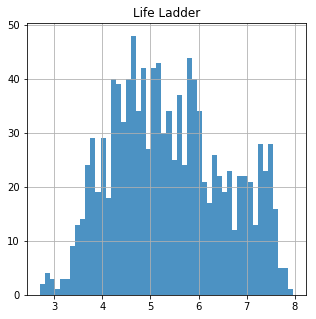

In [191]:
data = dropped.copy()
data['year'] = data['year'] - 2000
_ = data[['Life Ladder']].hist(bins=50, figsize=(5,5), alpha=0.8)
plt.show()

 * As one of the assumptions that Linear Regresion model need meet, target variable should be normal distribution. 
 * As shown above, the distribution of the indicator Life Ladder basicly is a normal distribution. Thus, it is not necessary to transform it.

### 2.b EDA – the search for good predictors (12 marks)
* Rename columns such that the data set is better for visualization
* Draw histogram plot for each feature and choose features that comform to normal distribution
* Draw scatter matrix and correlation matrix to choose features that are correlated to happniess and not quite correlated between them.

In [195]:
name_table = {
    'Life Ladder': 'happiness', 
    'Log GDP per capita': 'gdp_pc',
    'Social support': 'support',
    'Population, total': 'pop',
    'Total tax and contribution rate (% of profit)': 'tax',
    'GDP growth (annual %)': 'gdp_g',
    'Healthy life expectancy at birth': 'life_expected',
    'Freedom to make life choices': 'choice',
    'Generosity': 'generosity',
    'Perceptions of corruption': 'corruption',
    'Positive affect': 'positive',
    'Negative affect': 'negative',
    'Confidence in national government': 'gov_confidence',
    'Democratic Quality': 'democoratic',
    'Delivery Quality': 'delivery',
    'Standard deviation of ladder by country-year': 'sd_country_year',
    'Standard deviation/Mean of ladder by country-year': 'sd_m_country_year',
    'GINI index (World Bank estimate), average 2000-16': 'gini',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'unemployment'
}
data = data.rename(columns=name_table)
data.head()

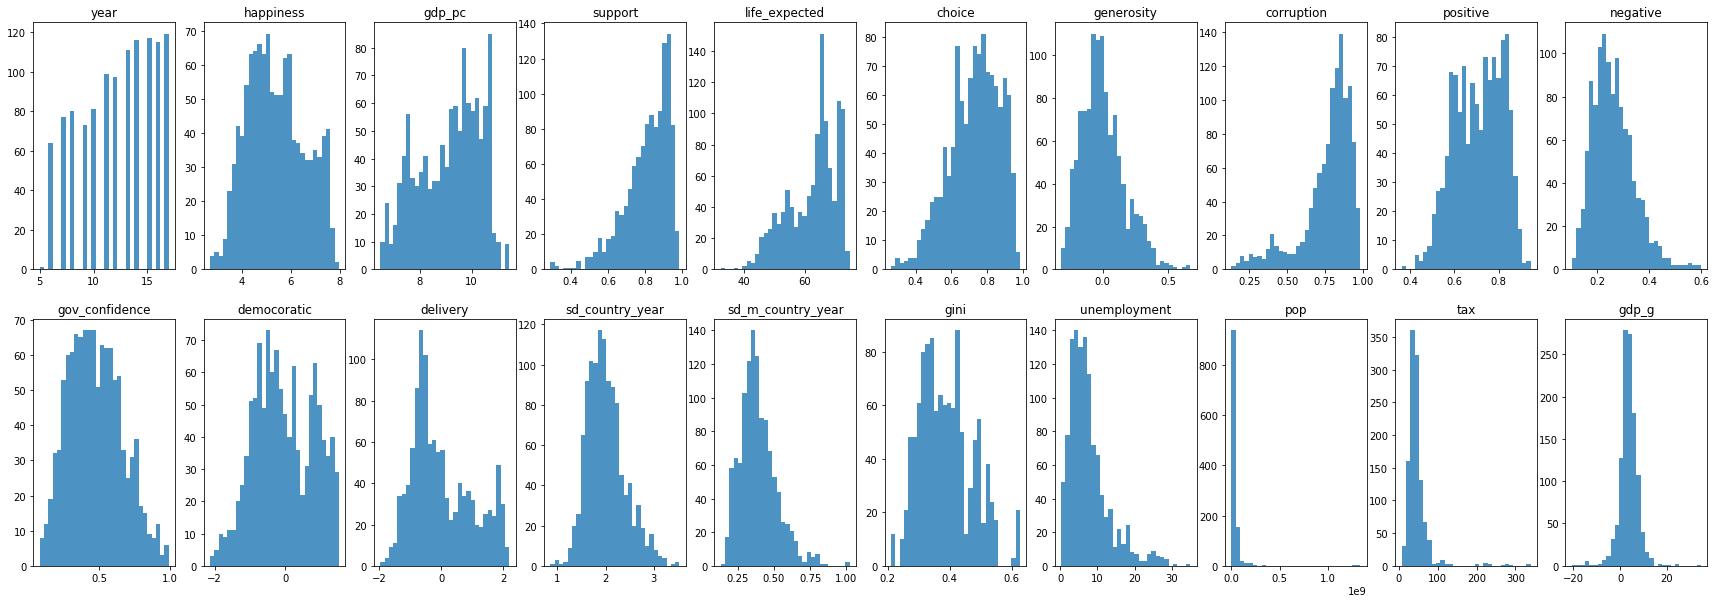

In [86]:
f, ax = plt.subplots(2, 10, figsize=(30, 10))

for i in range(0, len(data.columns)):
    c = 10
    f = data.columns[i]
    sub = ax[i//c, i%c]
    sub.hist(data[f], bins=30, alpha=0.8)
    sub.set_title(f)
plt.show()    

* Feartures **year**, **pop** and **tax** are dropped since they are extremely skewed 

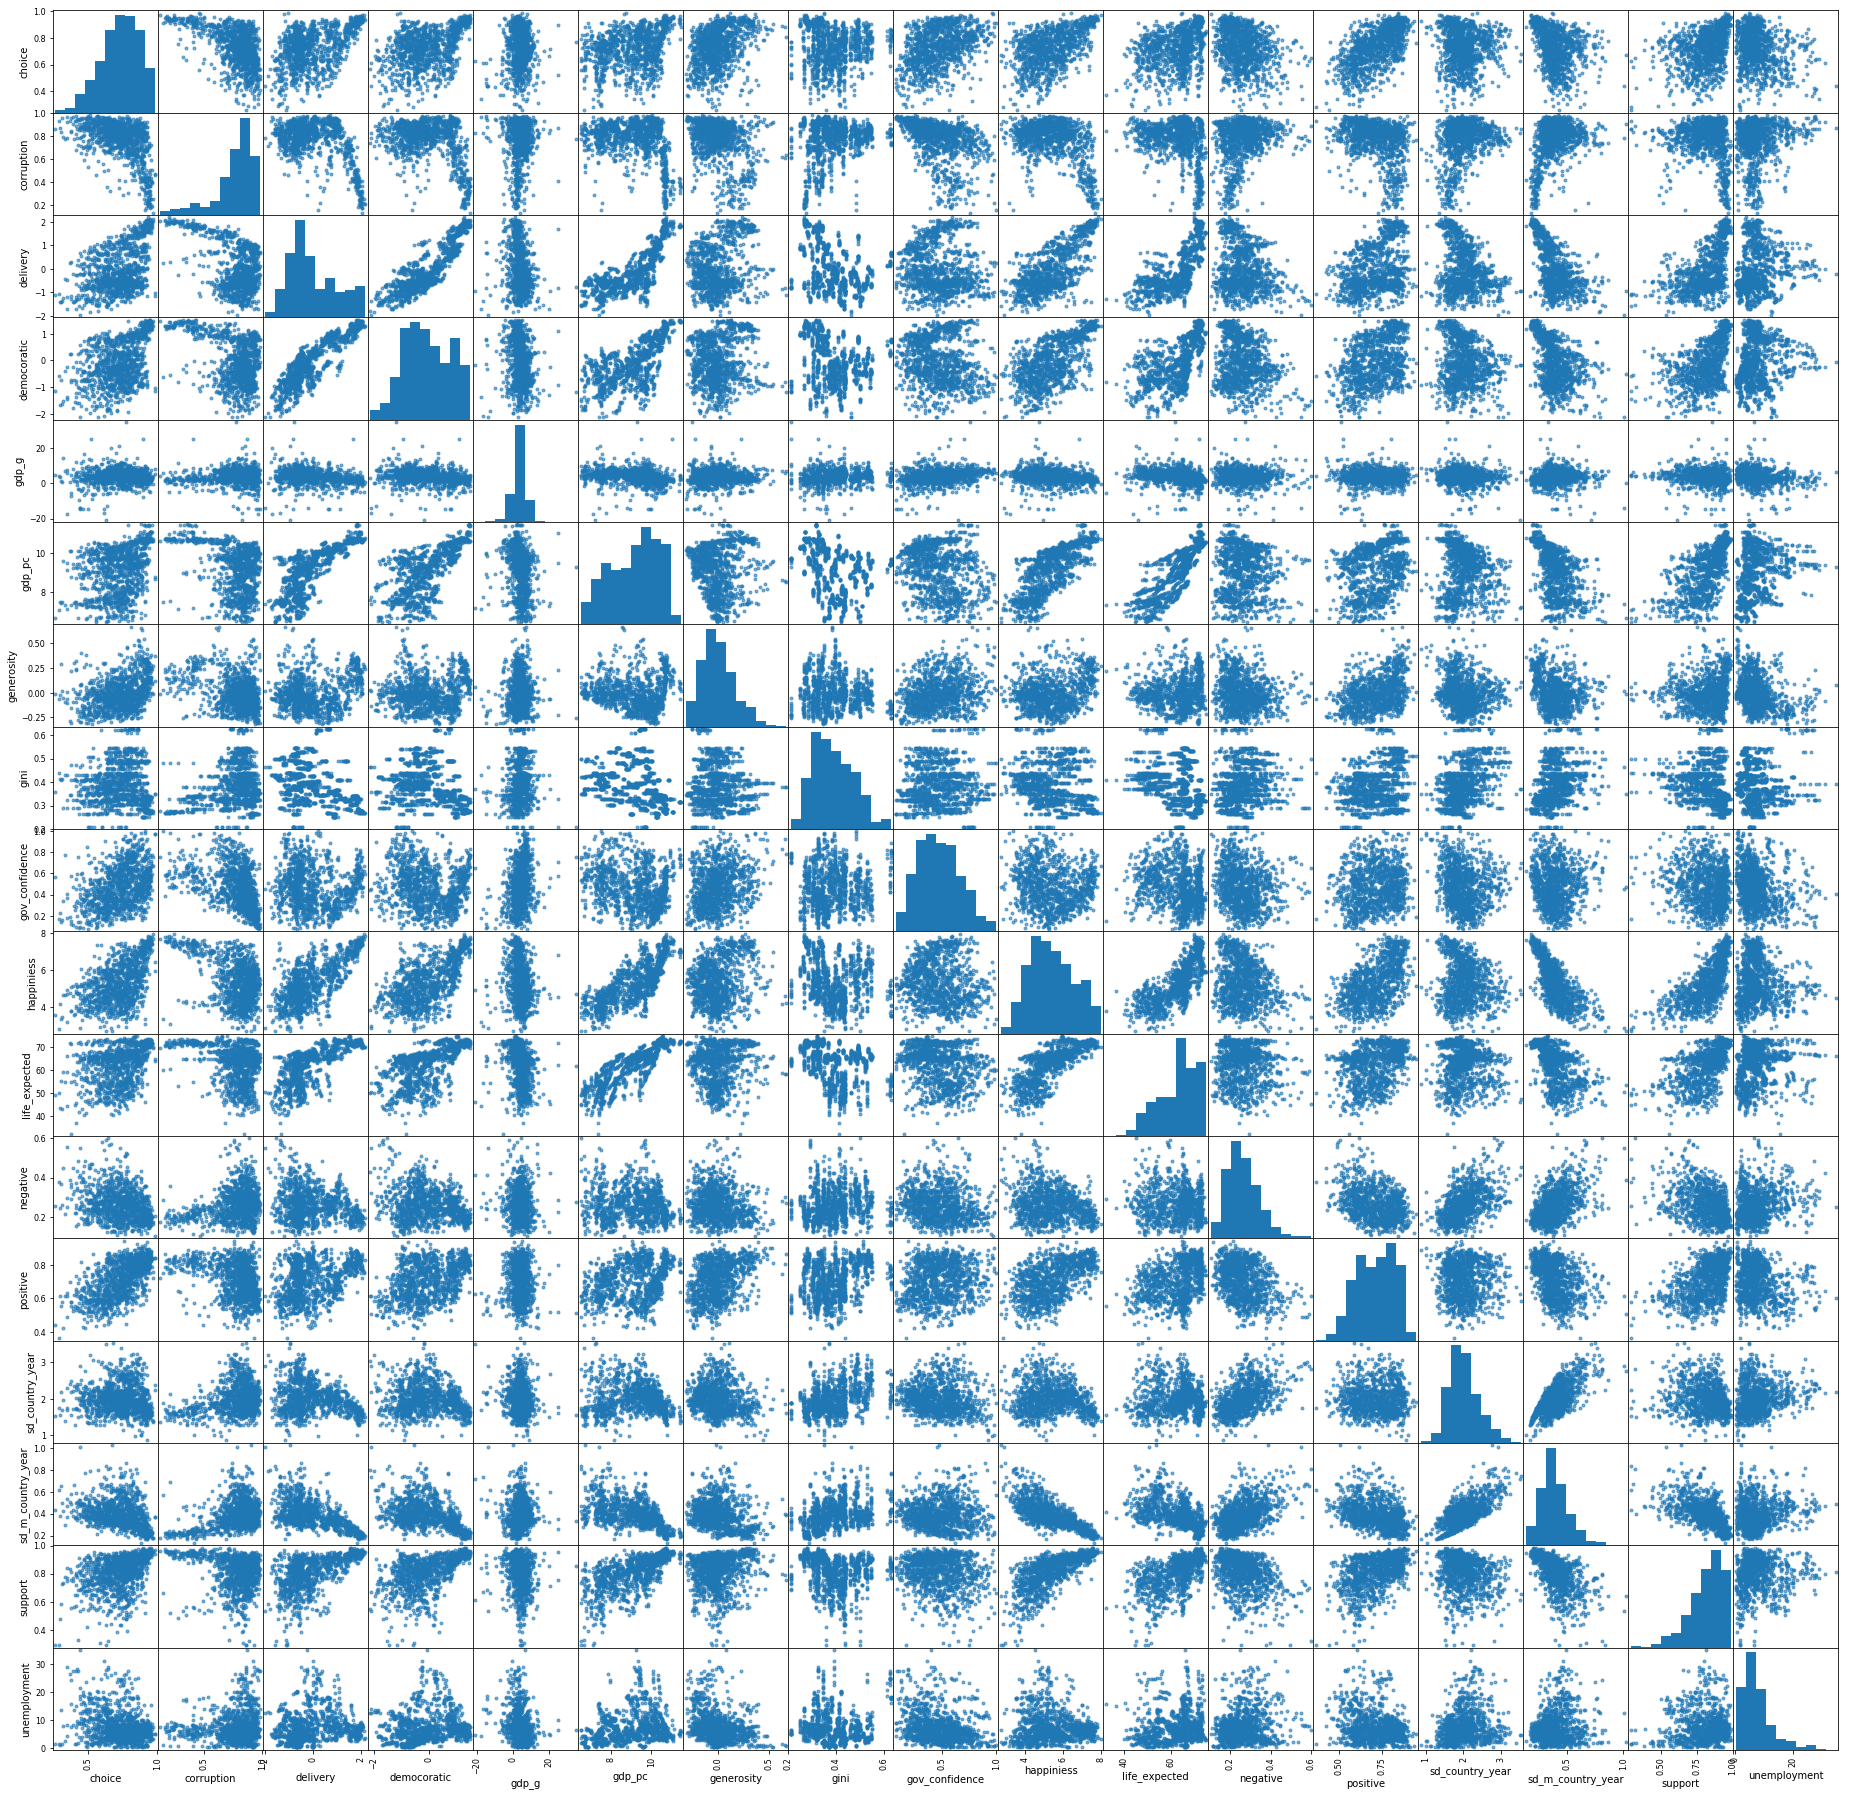

In [81]:
_ = scatter_matrix(data[data.columns.difference(['pop', 'tax', 'year'])], alpha=0.6, figsize=(32, 32))
plt.show()

In [87]:
data[data.columns.difference(['pop', 'tax', 'year'])].corr()

,choice,corruption,delivery,democoratic,gdp_g,gdp_pc,generosity,gini,gov_confidence,happiness,life_expected,negative,positive,sd_country_year,sd_m_country_year,support,unemployment
choice,1.000000,-0.522109,0.495913,0.468219,0.047246,0.370837,0.375087,0.010328,0.402482,0.549379,0.380844,-0.276404,0.612966,-0.050256,-0.349495,0.412240,-0.254771
corruption,-0.522109,1.000000,-0.540817,-0.395507,0.038378,-0.338150,-0.331697,0.245682,-0.422003,-0.464561,-0.309077,0.255493,-0.335740,0.287571,0.385362,-0.214412,0.127145
delivery,0.495913,-0.540817,1.000000,0.880904,-0.220068,0.798885,0.218686,-0.358979,-0.070721,0.729272,0.717943,-0.246115,0.377957,-0.276500,-0.592745,0.565458,0.111509
democoratic,0.468219,-0.395507,0.880904,1.000000,-0.196255,0.696758,0.119209,-0.240318,-0.153750,0.641187,0.616825,-0.227216,0.394266,-0.167957,-0.482026,0.547639,0.116708
gdp_g,0.047246,0.038378,-0.220068,-0.196255,1.000000,-0.251740,0.043234,0.117989,0.276211,-0.177877,-0.232893,-0.056944,-0.035028,-0.097112,0.014304,-0.130820,-0.218060
gdp_pc,0.370837,-0.338150,0.798885,0.696758,-0.251740,1.000000,0.025104,-0.343128,-0.193890,0.782985,0.856864,-0.125721,0.326417,-0.109923,-0.574851,0.670213,0.215858
generosity,0.375087,-0.331697,0.218686,0.119209,0.043234,0.025104,1.000000,-0.083007,0.257021,0.251401,0.073415,-0.157738,0.396977,-0.167642,-0.207309,0.131232,-0.314030
gini,0.010328,0.245682,-0.358979,-0.240318,0.117989,-0.343128,-0.083007,1.000000,0.035174,-0.207565,-0.343839,0.131946,0.269180,0.397650,0.352812,-0.173975,0.013099
gov_confidence,0.402482,-0.422003,-0.070721,-0.153750,0.276211,-0.193890,0.257021,0.035174,1.000000,-0.099048,-0.216427,-0.182298,0.139296,-0.146221,0.021928,-0.173755,-0.243568
happiness,0.549379,-0.464561,0.729272,0.641187,-0.177877,0.782985,0.251401,-0.207565,-0.099048,1.000000,0.766239,-0.243818,0.567479,-0.164790,-0.757231,0.713091,-0.073549


### Discuss
* As shown above, features **gov_confidence** and **unemployment** have low correlations to happniess. Thus, the two feature should not be chosen.
* All three features , **life_expected**, **delivery** , **democoratic** and **gdp_pc** indicate high correlations to happniess. However, the correlations among them are also very high. To preven multicollinearity, only one should be chosen
* **sd_country_year** and **sd_m_country_year** are hard to intrepret, thus they will not be considered as well.
* Based on the above the chosen features are listed below:

In [88]:
chosen_features = [
    'gdp_pc',  
    'choice',
    'generosity', 
    'corruption', 
    'positive', 
    'negative', 
    'gini', 
    'gdp_g',
    'support'
]

### Task 3

In [89]:
all_combinations = []
for length in range(1, len(chosen_features)+1):
    for subset in itertools.combinations(chosen_features, length):
        all_combinations.append(subset)
all_combinations

[('gdp_pc',),
 ('choice',),
 ('generosity',),
 ('corruption',),
 ('positive',),
 ('negative',),
 ('gini',),
 ('gdp_g',),
 ('support',),
 ('gdp_pc', 'choice'),
 ('gdp_pc', 'generosity'),
 ('gdp_pc', 'corruption'),
 ('gdp_pc', 'positive'),
 ('gdp_pc', 'negative'),
 ('gdp_pc', 'gini'),
 ('gdp_pc', 'gdp_g'),
 ('gdp_pc', 'support'),
 ('choice', 'generosity'),
 ('choice', 'corruption'),
 ('choice', 'positive'),
 ('choice', 'negative'),
 ('choice', 'gini'),
 ('choice', 'gdp_g'),
 ('choice', 'support'),
 ('generosity', 'corruption'),
 ('generosity', 'positive'),
 ('generosity', 'negative'),
 ('generosity', 'gini'),
 ('generosity', 'gdp_g'),
 ('generosity', 'support'),
 ('corruption', 'positive'),
 ('corruption', 'negative'),
 ('corruption', 'gini'),
 ('corruption', 'gdp_g'),
 ('corruption', 'support'),
 ('positive', 'negative'),
 ('positive', 'gini'),
 ('positive', 'gdp_g'),
 ('positive', 'support'),
 ('negative', 'gini'),
 ('negative', 'gdp_g'),
 ('negative', 'support'),
 ('gini', 'gdp_g'),
 

In [126]:
all_combinations_df = pd.DataFrame()
for c in all_combinations:
    all_combinations_df = all_combinations_df.append({f: 1 if f in c else 0 for f in chosen_features}, ignore_index=True)
    
all_combinations_df['f test'] = all_combinations_df['r^2'] =  all_combinations_df['aic'] = all_combinations_df['f_pvalue'] = all_combinations_df['rmse'] = all_combinations_df['no of p>0.05'] = all_combinations_df['df'] = 0    
all_combinations_df['formula'] = ''

all_combinations_df.head()

,choice,corruption,gdp_g,gdp_pc,generosity,gini,negative,positive,support,f test,r^2,aic,f_pvalue,rmse,no of p>0.05,df,formula
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,


In [127]:
for i, row in all_combinations_df.iterrows():
    features = [f for f in chosen_features if row[f] == 1]
    formula = 'happiness ~ 1 + ' + ' + '.join(features)
    mod = smf.ols(formula=formula, data=data).fit()
    
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("formula")] = formula
    
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("aic")] = mod.aic
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("f test")] = mod.fvalue 
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("r^2")] = mod.rsquared
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("f_pvalue")] = mod.f_pvalue
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("rmse")] = sqrt(mean_squared_error(data.happiness, mod.fittedvalues))
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("no of p>0.05")] = len([p for p in mod.pvalues if p > 0.05])
    all_combinations_df.iloc[i, all_combinations_df.columns.get_loc("df")] = mod.df_model
    
all_combinations_df.head()

,choice,corruption,gdp_g,gdp_pc,generosity,gini,negative,positive,support,f test,r^2,aic,f_pvalue,rmse,no of p>0.05,df,formula
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1818.907743,0.613065,2526.515002,6.053504e-239,0.724558,0,1.0,happiness ~ 1 + gdp_pc
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.267748,0.301817,3205.273866,1.173655e-91,0.973283,0,1.0,happiness ~ 1 + choice
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,77.451402,0.063202,3543.357628,4.906438e-18,1.127398,0,1.0,happiness ~ 1 + generosity
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.943650,0.215817,3338.859272,1.256410e-62,1.031486,0,1.0,happiness ~ 1 + corruption
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,545.296239,0.322032,3171.484659,5.383533e-99,0.959089,0,1.0,happiness ~ 1 + positive


In [128]:
all_significant = all_combinations_df[all_combinations_df['no of p>0.05'] == 0]
all_significant

,choice,corruption,gdp_g,gdp_pc,generosity,gini,negative,positive,support,f test,r^2,aic,f_pvalue,rmse,no of p>0.05,df,formula
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1818.907743,0.613065,2526.515002,6.053504e-239,0.724558,0,1.0,happiness ~ 1 + gdp_pc
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.267748,0.301817,3205.273866,1.173655e-91,0.973283,0,1.0,happiness ~ 1 + choice
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,77.451402,0.063202,3543.357628,4.906438e-18,1.127398,0,1.0,happiness ~ 1 + generosity
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.943650,0.215817,3338.859272,1.256410e-62,1.031486,0,1.0,happiness ~ 1 + corruption
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,545.296239,0.322032,3171.484659,5.383533e-99,0.959089,0,1.0,happiness ~ 1 + positive
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72.558947,0.059447,3547.958042,5.022757e-17,1.129656,0,1.0,happiness ~ 1 + negative
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,51.686496,0.043083,3567.793975,1.170701e-12,1.139440,0,1.0,happiness ~ 1 + gini
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.509730,0.031640,3581.464526,1.247334e-09,1.146233,0,1.0,happiness ~ 1 + gdp_g
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1281.606054,0.690853,2270.408703,4.068588e-293,0.647645,0,2.0,happiness ~ 1 + gdp_pc + choice
10,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1147.712907,0.666805,2356.558245,1.852584e-274,0.672363,0,2.0,happiness ~ 1 + gdp_pc + generosity


In [121]:
all_significant_high_rsq = all_significant[all_significant['r^2']>0.76]
all_significant_high_rsq

,choice,corruption,gdp_g,gdp_pc,generosity,gini,negative,positive,support,f test,r^2,aic,f_pvalue,rmse,no of p>0.05,df,formula
168,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,922.624644,0.763210,1967.772248,0.0,0.566809,0,4.0,happiness ~ 1 + gdp_pc + corruption + positive...
273,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,749.882976,0.766216,1955.075361,0.0,0.563198,0,5.0,happiness ~ 1 + gdp_pc + choice + corruption +...
293,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,756.566194,0.767802,1947.248947,0.0,0.561285,0,5.0,happiness ~ 1 + gdp_pc + generosity + corrupti...
312,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,742.958088,0.764550,1963.241365,0.0,0.565202,0,5.0,happiness ~ 1 + gdp_pc + corruption + positive...
384,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,637.747083,0.769996,1938.330569,0.0,0.558627,0,6.0,happiness ~ 1 + gdp_pc + choice + generosity +...
395,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,605.640437,0.760721,1983.796878,0.0,0.569780,0,6.0,happiness ~ 1 + gdp_pc + choice + generosity +...
403,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,628.937221,0.767523,1950.628359,0.0,0.561622,0,6.0,happiness ~ 1 + gdp_pc + choice + corruption +...
418,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,634.099007,0.768979,1943.407018,0.0,0.559861,0,6.0,happiness ~ 1 + gdp_pc + generosity + corrupti...
432,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,622.416440,0.765659,1959.816243,0.0,0.563870,0,6.0,happiness ~ 1 + gdp_pc + corruption + positive...
467,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,549.766038,0.771159,1934.502290,0.0,0.557213,0,7.0,happiness ~ 1 + gdp_pc + choice + generosity +...


In [122]:
all_significant_high_rsq_low_rmse = all_significant_high_rsq[all_significant_high_rsq.rmse < 0.56]
all_significant_high_rsq_low_rmse

,choice,corruption,gdp_g,gdp_pc,generosity,gini,negative,positive,support,f test,r^2,aic,f_pvalue,rmse,no of p>0.05,df,formula
384,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,637.747083,0.769996,1938.330569,0.0,0.558627,0,6.0,happiness ~ 1 + gdp_pc + choice + generosity +...
418,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,634.099007,0.768979,1943.407018,0.0,0.559861,0,6.0,happiness ~ 1 + gdp_pc + generosity + corrupti...
467,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,549.766038,0.771159,1934.502290,0.0,0.557213,0,7.0,happiness ~ 1 + gdp_pc + choice + generosity +...


#### Final model chosen
    * According to okam razors, the model with index=384 is chosen, as shown below.

In [164]:
final_model = smf.ols(formula='happiness ~ 1 + choice + corruption + gdp_pc + generosity + positive + support', data=data).fit()

#### Model interpretation

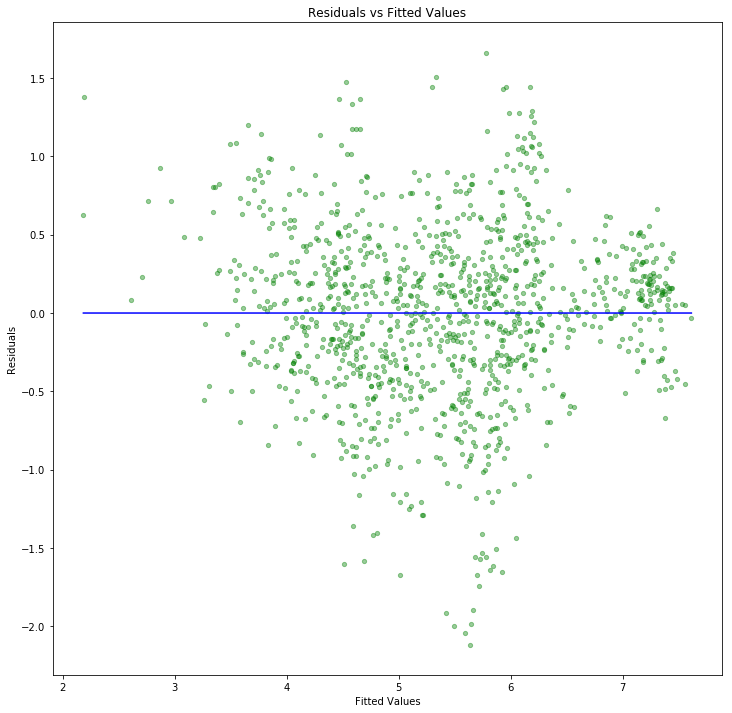

In [169]:
x = final_model.fittedvalues 
y = final_model.resid 

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c="g", alpha=0.4, s=18)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title('Residuals vs Fitted Values')

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='b')

plt.show()

#### ???? a few other stuff is needed for the model interpretation